In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

In [4]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/assign_bullets_para_wordembed/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

### **Init**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [6]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [7]:
def print_examples(model_name_list, df, n_examples=10):
    
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
        for model_name in model_name_list:
            model, tokenizer = import_model_tok(model_name)
            model = model.to(device)
            
            summ_enc = model.generate(
                tokenizer.encode(row.text, return_tensors='pt').to(device),
                min_length = config.ONE_BULLET_MIN_LEN,
                max_length = config.ONE_BULLET_MAX_LEN,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
            summ_num_tok = len(summ_enc)
            summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

            print('Prediction\n%s (%d tok):\n'%(model_name, summ_num_tok))
            print(fill(summ, 100))
            print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Plot Evaluation

In [8]:
def plot_evaluation_bullet_by_bullet(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_bullet_by_bullet.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+2))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-1]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
        
    box_plt_list.append(
        plt.boxplot(
        df['cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-1]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.yticks(np.linspace(0, 100, 21))
    plt.xticks(xticks, config.ROUGE_TYPES+['Cosine Sim'], fontsize='x-large')
    plt.show()

In [9]:
def plot_evaluation_grouping_bullets(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_grouped.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, len(config.ROUGE_TYPES)+2))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks[:-1]+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))
    
    box_plt_list.append(
        plt.boxplot(
        df['cosine_sim'].tolist(),
        positions=[xticks[-1]],
        sym='+',
        widths=0.4,
        patch_artist=False,
        meanline=True,
        showmeans=True))

    for i, bp in enumerate(box_plt_list[:-1]):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.yticks(np.linspace(0, 100, 21))
    plt.xticks(xticks, config.ROUGE_TYPES+['Cosine Sim'], fontsize='x-large')
    plt.show()

## **Sentence-Transformers**

In [10]:
data_dir_st = data_dir + 'st/'

In [11]:
df_train = pd.read_csv(data_dir_st + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir_st + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir_st + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [12]:
print_examples([
    'sshleifer/distilbart-cnn-12-6',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/'],
    df_train)

(9781912776696, 'hh-5')
Kaplan-Meier curves provide a way of plotting the distribution of a time-to-event endpoint. In
Figure 2.1 the dashed line shows that at 24 months' follow-up the estimated survival probability is
54%. Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor receptor 2 (HER2)-positive metastatic breast cancer treated either with or without
trastuzumab. The Kaplan-Meier curve steps down at time points at which deaths occur, while censored
observations are denoted by notches on the curve. In this study, the follow-up period ranged from 3
months to 74 months.

Prediction
sshleifer/distilbart-cnn-12-6 (66 tok):

 Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor 

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/ (26 tok):

Treatment of DKA should be undertaken without delay. The initial cornerstone of treatment is fluid
replacement and insulin administration.

Reference:
Treatment of DKA is by fluid and electrolyte replacement, intravenous insulin and treatment of the
underlying cause, when known.

####################################################################################################

(9781910797495, 'chp1')
Because it is an experience, pain itself cannot be measured directly. Pain, like consciousness
itself, is constructed by complex brain processes that are strongly affected by a person's
attitudes, beliefs, personality and interpretation of the significance of nociceptive stimuli.
Central to the understanding of clinical pain is the concept that pain may be present without an
obvious peripheral source or cause. Mechanisms of neuropathic pain. Definition. Neu

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (29 tok):

Hepatocellular carcinoma (hepatoma, HCC) is a common cause of mortality in the developing world.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/ (29 tok):

Hepatocellular carcinoma (hepatoma, HCC) is a common cause of mortality in the developing world.

Reference:
Hepatocellular carcinoma often has few specific symptoms or signs.

####################################################################################################

(9781910797273, 'chp6')
Promoting repair has been an unexplored sphere of MS therapy. Recently, in animal models of
demyelination, LINGO antagonists have been shown to promote oligodendrocyte differentiation and
myelination in vitro. Initiated in 2013, the first multinational Phase II trial of anti-LINGO-1
antibodies in patients with acute optic neuritis has shown an

##### Print Val Examples

In [13]:
print_examples([
    'sshleifer/distilbart-cnn-12-6',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/'],
    df_val)

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
sshleifer/distilbart-cnn-12-6 (46 tok):

 Mechanica

Prediction
sshleifer/distilbart-cnn-12-6 (80 tok):

 The potential sensitivity of a given cancer to immuno-oncology therapies will depend on the ability
of the tumor to trigger an immune response (immunogenicity) Cancer is characterized by an
accumulation of genetic mutations, many of which result in the expression of cancer-specific
antigens. Somatic mutation rates differ markedly, both between tumor types and within an individual
tumor type.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (31 tok):

Tumors with high somatic mutation rates may be more susceptible to immuno-oncology therapies than
those with lower mutation rates.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/ (37 tok):

The potential sensitivity of a given cancer to immuno-oncology therapies will depend on the ability
of the tumor to trigger an immune response (immunogenicity).

Ref

Prediction
sshleifer/distilbart-cnn-12-6 (57 tok):

 Current evidence suggests that the risk of major congenital malformations is two to four times
higher with the use of VPA than with other AEDs such as CBZ and LTG. There are still insufficient
data regarding the safety of other modern AEDs.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (19 tok):

High-dose exposure to VPA in utero may impair later cognitive function.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/ (24 tok):

There is no clear data indicating differences in safety among PHT, CBZ, PB and PRM.

Reference:
The risk of major malformations in babies exposed in utero seems to be greater with sodium valproate
(VPA) than with other AEDs.

####################################################################################################



##### Print Test Examples

In [14]:
print_examples([
    'sshleifer/distilbart-cnn-12-6',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/'],
    df_test)

(9781908541277, 'ch_8')
Indications. OXC has a similar spectrum of efficacy to CBZ against partial and tonic-clonic
seizures. It tends to be better tolerated than CBZ with fewer neurotoxic side effects. Dosage. The
recommended starting dose for OXC in adults is 150-600 mg daily in two doses. The dose can be
titrated upwards as clinically indicated to 3000-4000 mg daily. A starting dose of 5 mg/kg daily in
children over 3 years of age can be prescribed, increasing gradually to a maintenance dose of about
30 mg/kg daily. Patients already on CBZ may be switched immediately to OXC using a dosage ratio of
1.5 OXC to 1 CBZ. Particular care in immediate switching needs to be taken when the daily CBZ dose
exceeds 1200 mg. Plasma concentrations of the clinically active metabolite of OXC increase linearly
with dose. No studies, however, have attempted to relate elevated plasma levels to efficacy or
toxicity.

Prediction
sshleifer/distilbart-cnn-12-6 (41 tok):

 OXC has a similar spectrum of effi

Prediction
sshleifer/distilbart-cnn-12-6 (51 tok):

 Obesity is associated with hypertension, tachycardia, left ventricular hypertrophy, increased
collagen deposition, reduced cardiac contractility and increased end-diastolic pressure. The major
circulatory complications are increased total and pulmonary blood volume.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (45 tok):

Overweight/obesity as a whole predisposes to, or is associated with, numerous cardiac complications
such as coronary heart disease (CHD), atrial fibrillation, heart failure and sudden cardiac death.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/ (35 tok):

Overweight/obesity predisposes to cardiac complications such as coronary heart disease (CHD), atrial
fibrillation, heart failure and sudden cardiac death.

Reference:
Obesity significantly affects cardiometabolic status and r

Prediction
sshleifer/distilbart-cnn-12-6 (84 tok):

 Gallbladder carcinoma is the fifth most common gastrointestinal (GI) cancer in the USA. Incidence
and mortality are very high in certain Latin American countries, especially Chile. Inflammation may
occur as a result of gallstones, gallbladder polyps, chronic Salmonella infection, congenital
biliary cysts, abnormal pancreaticobiliary duct junction, carcinogen exposure and certain drugs.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (32 tok):

Gallbladder carcinoma is the fifth most common gastrointestinal (GI) cancer in the USA and is the
most common GI cancer in Native Americans.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/ (32 tok):

Gallbladder carcinoma is the fifth most common gastrointestinal (GI) cancer in the USA and is the
most common GI cancer in Native Americans.

Reference:
Gallblad

##### Summarize Test

In [12]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary'] = summs
    
    df.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df

In [13]:
summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)

100%|██████████| 25/25 [15:57<00:00, 38.29s/it]


bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
              chp6     Depression is complex, and understanding and h...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     Lipid disorders and hypertension are exacerbat...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Prevention and management. By far the most res...   
              chp6     The forms of psychological therapy best suppor...   
              chp6     The effectiveness of individual treatments is ...   
              chp6     Monitoring use of antidepressants. For people ...   
              chp6     Suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Type 2 diabetes mellitus is a preventable dise...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                                                 summary  
book          chapter                                                     
9781910797631 chp6      Preventive strategies may be directed toward ...  
              chp6      The forms of psychological therapy best suppo...  
              chp6      Current evidence suggests that better outcome...  
              chp6      Many people discontinue their antidepressant ...  
              chp6      Suicidal ideas and acts may be increased in t...  
...                                                                  ...  
9781908541680 ch_4      Obesity is associated with hypertension, tach...  
              ch_4      Obesity is associated with hypertension, tach...  
              ch_4      Obesity is associated with hypertension, tach...  
              ch_4      The International Diabetes Federation updated...  
              ch_4      A modest reduction in weight by intensive lif...  

[242 rows x 4 columns]

In [ ]:
summarize(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/',
    df_test, 10)

 80%|████████  | 20/25 [1:45:41<21:16, 255.23s/it]  

In [ ]:
summarize(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/',
    df_test, 10)

### **Evaluation**

In [ ]:
from datasets import load_metric

metric = load_metric("rouge")

from sentence_transformers import SentenceTransformer

sentence_distilroberta = SentenceTransformer('paraphrase-distilroberta-base-v1')

#### Evaluate summaries bullet by bullet

In [ ]:
def evaluate_model_bullet_by_bullet(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
    
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['cosine_sim'] =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_bullet_by_bullet.csv')
    
    return df_eval

In [ ]:
evaluate_model_bullet_by_bullet('sshleifer/distilbart-cnn-12-6')

evaluate_model_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

evaluate_model_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/')

#### Evaluate summaries grouping bullets

In [70]:
def evaluate_model_grouping_bullets(model_name_or_path):
    df_eval = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '.csv').set_index(['book', 'chapter'])
    
    df_eval = df_eval.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary': lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)
    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf] =\
                rouge_res.map(lambda score: 100*score[r][0][i])
            
    cosine_sim = lambda a, b: (np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b)))
    df_eval['cosine_sim'] =\
    df_eval[['bullets', 'summary']]\
        .apply(lambda row:
        100*cosine_sim(
            sentence_distilroberta.encode(row[1]),
            sentence_distilroberta.encode(row[0])), axis=1)
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_grouped.csv')
    
    return df_eval

In [71]:
evaluate_model_grouping_bullets('sshleifer/distilbart-cnn-12-6')

evaluate_model_grouping_bullets(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

evaluate_model_grouping_bullets(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/')

,,text,bullets,summary,rouge1_precision,rouge1_recall,rouge1_fmeasure,rouge2_precision,rouge2_recall,rouge2_fmeasure,rougeL_precision,rougeL_recall,rougeL_fmeasure,cosine_sim
book,chapter,,,,,,,,,,,,,
9781910797631,chp6,Prevention and management. By far the most res...,The treatment rather than the prevention of de...,Prevention and management strategies may be di...,34.972678,37.209302,36.056338,4.395604,4.678363,4.532578,16.939891,18.023256,17.464789,73.560482
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,Gallstones are a significant cause of morbidit...,55.303030,57.031250,56.153846,25.190840,25.984252,25.581395,36.363636,37.500000,36.923077,87.506872
9781908541277,ch_12,Nearly 1 in 3 patients reports significant con...,Depression and anxiety are common in patients ...,Depression is the most prevalent psychiatric c...,57.553957,53.691275,55.555556,35.507246,33.108108,34.265734,49.640288,46.308725,47.916667,80.067378
9781910797907,chp6,When to transfuse. There is no set standard wi...,The decision for transfusion therapy relates t...,There is no set standard with regard to transf...,62.608696,54.961832,58.536585,28.947368,25.384615,27.049180,35.652174,31.297710,33.333333,87.325555
9781908541277,ch_8,Modern antiepileptic drugs. After a hiatus of ...,Sixteen new antiepileptic drugs (AEDs) have be...,The advent of new antiepileptic drugs has prov...,26.923077,40.384615,32.307692,5.194805,7.843137,6.250000,15.384615,23.076923,18.461538,70.502198
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,Acute exacerbations of chronic obstructive pul...,36.029412,55.056180,43.555556,20.740741,31.818182,25.112108,26.470588,40.449438,32.000000,86.179012
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,People with schizophrenia exhibit decreased vo...,43.478261,58.252427,49.792531,25.547445,34.313725,29.288703,35.507246,47.572816,40.663900,89.764613
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,The use of broad NGS gene panels may support t...,37.903226,38.524590,38.211382,9.756098,9.917355,9.836066,23.387097,23.770492,23.577236,72.414923
9781910797105,ch04,Studies in twins involve probands with schizop...,Identical twins show a 45% concordance rate. H...,The concordance rates of twins with schizophre...,27.450980,39.436620,32.369942,4.950495,7.142857,5.847953,15.686275,22.535211,18.497110,81.606978


#### Plot evaluation bullet by bullet

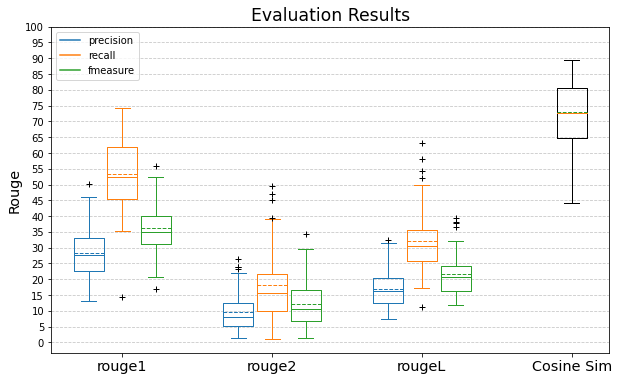

In [74]:
plot_evaluation_bullet_by_bullet('sshleifer/distilbart-cnn-12-6')

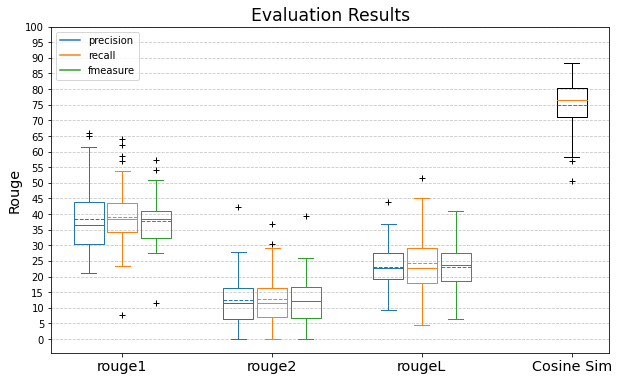

In [75]:
plot_evaluation_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

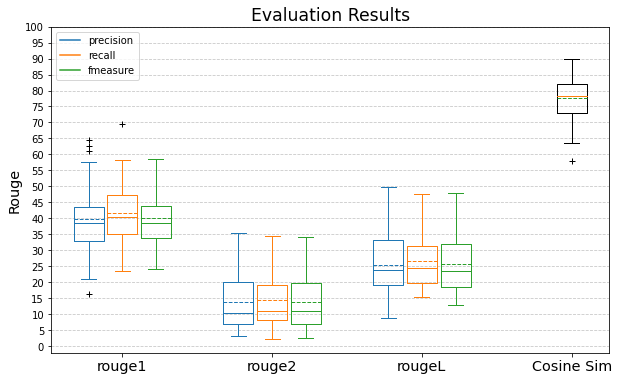

In [76]:
plot_evaluation_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/')

#### Plot evaluation grouping bullets

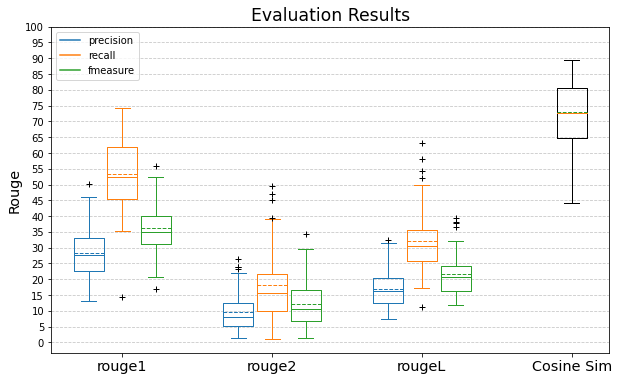

In [80]:
plot_evaluation_grouping_bullets('sshleifer/distilbart-cnn-12-6')

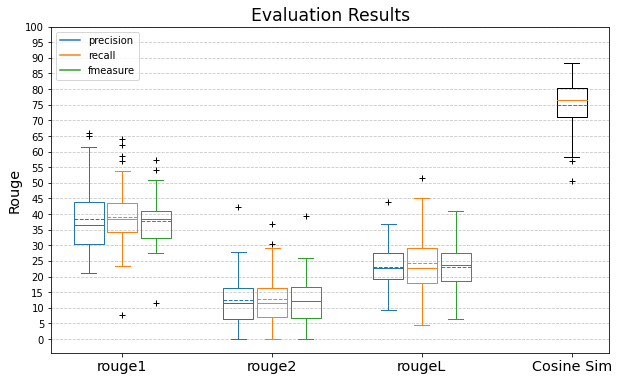

In [81]:
plot_evaluation_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

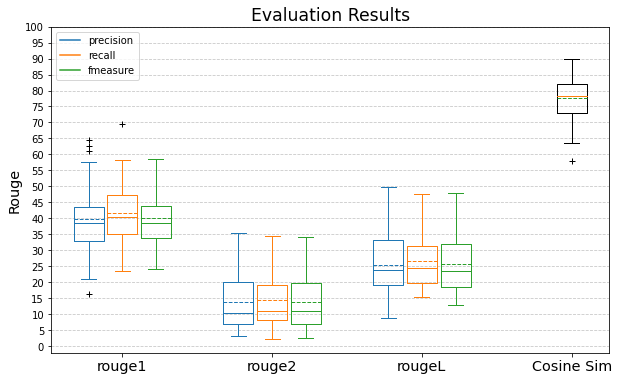

In [82]:
plot_evaluation_bullet_by_bullet(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_no_freeze_train/')